In [1]:
#モジュールの導入
import cv2
import numpy as np
from pathlib import Path
from google.cloud import vision
import os
import pandas as pd
import re
import io
import time
import math
import matplotlib.pyplot as plt
import glob
import base64

In [2]:
#ここで、環境変数”GOOGLE_APPLICATION_CREDENTIALS”にパスを通しています。
#絶対パスだと認証が通らなかったけど、相対パスだと認証が通りました。
#GoogleAPIの認証に必要です。
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './Acceleration-d235c14fd1a1.json'
client = vision.ImageAnnotatorClient()

In [3]:
#カレントディレクトリに画像の保存場所を作成。
cd= %pwd
work_path=os.path.join(cd,"work_space")
work_space=os.makedirs(work_path,exist_ok=True)

In [4]:
#make an inclined table parallel
def inclination_correct(path):
#画像の読み込み
    img_orig = cv2.imread(path)
#原画像の処理、エッジ抽出
    kernel = np.ones((2,2),np.uint8)
    img_erosion = cv2.erode(img_orig,kernel,iterations = 2)
    edges = cv2.Canny(img_erosion, 1,100, apertureSize=3)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #exract largest contour and its four courners
    contours_array = contours[np.argmax([len(contours[i]) for  i in range(len(contours))])][:,0]
    #judge as a left-top corner the point where the sum of its x and y is minimum (the other points are judged likewise)
    lu = contours_array[:,0]+contours_array[:,1]
    ru = contours_array[:,0]-contours_array[:,1]
    ld = -contours_array[:,0]+contours_array[:,1]
    rd = contours_array[:,0]+contours_array[:,1]
    lu_c = contours_array[np.argmin(lu)]
    ru_c = contours_array[np.argmax(ru)]
    ld_c = contours_array[np.argmax(ld)]
    rd_c = contours_array[np.argmax(rd)]

#calculate an inclination of the table by its four edges (a degree of inclination is an arctan of the slope converted to deg. from rad.)
    deg1 = math.degrees(math.atan((lu_c[0]-ld_c[0])/(ld_c[1]-lu_c[1])))
    deg2 = math.degrees(math.atan((ru_c[1]-lu_c[1])/(ru_c[0]-lu_c[0])))
    deg3 = math.degrees(math.atan((ru_c[0]-rd_c[0])/(rd_c[1]-ru_c[1])))
    deg4 = math.degrees(math.atan((rd_c[1]-ld_c[1])/(rd_c[0]-ld_c[0])))
    angle = sum([deg1,deg2,deg3,deg4])/4
    center = (round(sum([lu_c[0], ru_c[0], ld_c[0], rd_c[0]])/4),round(sum([lu_c[1], ru_c[1], ld_c[1], rd_c[1]])/4))
    height = img_orig.shape[0]                         
    width = img_orig.shape[1]  

#rotate the original image
    trans = cv2.getRotationMatrix2D(center, angle , 1)
    image2 = cv2.warpAffine(img_orig, trans, (width,height),flags=cv2.INTER_CUBIC,borderValue=(255, 255, 255))
    return image2
    #plt.imshow(image2)
    #cv2.imwrite("rotated2.png",th)


In [300]:
def DetectTableByHistogram(path,vhist_thresh = 1.5, hhist_thresh = 8):
    #vhist_thresh：y方向の白のピクセル数の最小値の何倍まで縦罫線として許容するかの変数。表が2つに分かれていて縦の長さが違う時などは、小さすぎると片方しか読み取れないことがある
    #hhist_thresh：x方向の白のピクセルの最大値の何分の一から横罫線として許容するかの変数。線がガタガタしてる時はうまく読み取れないことがあるので適当に調整してください
#widen black lines
    image2 = inclination_correct(path)
    img_gray= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
    kernel = np.ones((2,2),np.uint8)
    img_erosion = cv2.erode(img_gray,kernel,iterations = 1)
    ret, th = cv2.threshold(img_erosion,127,255,cv2.THRESH_BINARY) 

#detect vertical lines by a histgram of summation of white pixels along y-axis
    vhist = [sum(th[:,i]) for i in range(len(img_gray[0]))]
    thresh = min(vhist)*vhist_thresh
    vline_indices = np.where(vhist < thresh)
    vline_gen = []
    for x in vline_indices[0]:
        if (vhist[x] < vhist[x+1]) & (vhist[x] <= vhist[x-1]):
            vline_gen.append(x)
        
#divide the table into columns and detect horizontal lines in each column by a histgram of summation of white pixels along x-axis
    hhists = [[sum(th[:,vline_gen[j]:vline_gen[j+1]][i]) for i in range(len(th))] for j in range(len(vline_gen) - 1)]
    hline_gen_list = []
    for hhist in hhists:
        thresh_h = max(hhist)/hhist_thresh
        hline_indices = np.where(hhist < thresh_h)
        hline_gen = []
        for x in hline_indices[0]:
            if (hhist[x] < hhist[x+1]) & (hhist[x] <= hhist[x-1]):
                hline_gen.append(x)
        hline_gen_list.append(hline_gen)
    
#write numbers in each cell and plot
    fig = plt.figure(figsize = (18,24))
    ax = fig.add_subplot()
    index = 1
    for v in range(len(vline_gen)-1):
        for h in range(len(hline_gen_list[v])):
            ax.text(vline_gen[v],hline_gen_list[v][h],str(index),size = 13)
            index += 1
    ax.imshow(th,"gray")
    plt.savefig(os.path.join(work_path,"_numbered.png"))
    trimmed_table_list = [image2[:,vline_gen[i]:vline_gen[i+1]] for i in range(len(vline_gen) - 1)]
    
    return trimmed_table_list, hline_gen_list #return a list of trimmed image as cv2-matrices, and lists of horizontal line pixels of each columns

In [310]:
#OCRを行う関数。
def detect_text(path):#byte形式じゃないとOCRできません。numpyだと無理。
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
   
    #OCRの準備
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    #リストの設定。
    data_list_text=[]
    dict_list_y_corrdinate=[]
    #dict_list_x_corrdinate=[]
    
    for text in texts:
        data_list_text.append(text.description)
        y_arg=(text.bounding_poly.vertices[0].y+text.bounding_poly.vertices[2].y)/2 #平均
        y_arg=round(y_arg)
        dict_list_y_corrdinate.append(y_arg)
        
        #x座標の場合
        #x_arg=(text.bounding_poly.vertices[0].x+text.bounding_poly.vertices[2].x)/2 #平均
        #x_arg=round(x_arg)
        #dict_list_x_corrdinate.append(x_arg)
        
    
    if len(dict_list_y_corrdinate)!=0:
        dict_list_y_corrdinate.pop(0)
        #dict_list_x_corrdinate.pop(0)
        data_list_text.pop(0) 
        
    #del_index=[]
    #for i in range(len(dict_list_y_corrdinate)-1):
     #   if dict_list_y_corrdinate[i]==dict_list_y_corrdinate[i+1]:
      ##    del data_list_text[i:i+2]
           # data_list_text.insert(i,text_append)
            #del_index.append(i)
    
   # for i in del_index:
     #   dict_list_y_corrdinate.pop(i)
            


    return [data_list_text,dict_list_y_corrdinate] #出力は、OCRにかけたテキストデータと、OCRが認識しているy座標が存在する座標です。



        
    




In [7]:
#DetectTableByHistogramの一次元目は、画像と、横線の罫線の座標
#二次元目は、列ごとの画像}（打刻形式や、ドアなど）
#三次元目はy座標
demo=detect_text("/Users/tetra/Desktop/partsone/work_space/1.png")
demo

[['2D'], [528]]

In [210]:
#保存した号機管理表を上下に分けるコード。
def TableDivide(path):
    img = cv2.imread(path,0) #号機管理表を読み込む。
    
    ksize=9
    img_mask = cv2.bilateralFilter(img,ksize,75,75)
    #img_mask = cv2.medianBlur(img,ksize) #各ピクセルに対し、そこを中心に3*3のマスで輝度の平均を取る。
    
    #ピクセルの周りの白が２ピクセル以下であれば黒に、３以上であれば白に二値化される。黒のゴマ塩ノイズを消去するための処理
    
    #cv2.thresholdの第一引数は大値の二値化につかい、第二引数は、二値化した画像を出力する。
    ret, img_thresh = cv2.threshold(img_mask,60,255,cv2.THRESH_BINARY) 
    black_hist = []
    y_pixel = len(img_thresh) #順にy,xのピクセル数 
    x_pixel = len(img_thresh[0])
    
    for line in range(y_pixel):
        black_hist.append(np.sum(img_thresh[line])/255) #y軸の値に対し、横(x=const上)に白のピクセル数を取った合計※白=255,黒=0です
    
    breaks = []
    for i in reversed(range(1,y_pixel)):
        if (black_hist[i] == x_pixel) and (black_hist[i-1] != x_pixel): #yの値が大きい順から、y=Yで白一色だが、y=Y-1で白一色でないようなYを表のブレークとして格納
            breaks.append(i)
    breaks.sort()        
    
    #これ以後は、表の形によって変わる。
    #y座標のうち、全て白色のピクセルで構成されているものが、breaksに格納されている。
    if len(breaks)==4:
        year_table=img[breaks[1]:breaks[2]+2]
        cv2.imwrite(os.path.join(work_path,'year.png'), year_table)
        year_table=img[breaks[2]:]
        cv2.imwrite(os.path.join(work_path,"type_name.png"), year_table)
        

    else:
        year_table=img
        cv2.imwrite(os.path.join(work_path,"type_name.png"), year_table)

        
    
        
    return os.path.join(work_path,"type_name.png"),os.path.join(work_path,'year.png') #cv2の行列形式で、切り取った表をreturn


In [9]:
def Margin_cutting(img_path):
    img = cv2.imread(img_path,0) # 画像をグレースケールへと処理
    img_path=img_path.replace('.png', '')
    gray=img
    gray = 255*(gray < 128).astype(np.uint8) # 文字を白色に変更
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = img[y-2:y+h+5, x-2:x+w+2] # Crop the image - note we do this on the original image
    cv2.destroyAllWindows()
    cv2.imwrite("{}.png".format(img_path), rect) # Save the image
    return 

In [307]:
#黒線を検出する関数
def YearTableDetector(img):  #受け取りはcv2の行列形式。年式のみならず一般の表に適用可能
    
    kernel = np.array([[0, 0, 0, 0, 0,],
             [0, 0, 1, 0, 0,],
             [0, 1, 1, 1, 0,],
             [0, 0, 1, 0, 0,],
             [0, 0, 0, 0, 0,]],dtype = np.uint8) #１行目と５行目を[0,0,1,0,0]にすると縦方向の黒の膨張が強くなります
    
    #cv2.erodeは膨張。白い部分が小さくなり、黒い部分が増える。
    img_erode = cv2.erode(img,kernel, iterations = 1) #点線を実線にします。うまくつながらない場合はiterationsの回数をふやすなどの必要があります。
#    plt.imshow(img_erode,"gray")

    black_hist_x = []
    black_hist_y = []
    y_pixel = len(img_erode) 
    x_pixel = len(img_erode[0])
    
    for line in range(y_pixel):
        black_hist_x.append(np.sum(img_erode[line])/255)#y軸の値に対し、横(x=const上)に白のピクセル数を取った合計
    for row in range(x_pixel):
        black_hist_y.append(np.sum(img_erode[:,row])/255)#x軸の値に対し、横(y=const上)に白のピクセル数を取った合計
        
    #ピクセルの合計数の最小+10以内の行or列を1,それ以外を0に変換する。罫線(黒が最も多い行、列)が1、それ以外が0となる
    y_int = [int(black_hist_x[i] < np.min(black_hist_x)  +1) for i in range(y_pixel)] 
    x_int = [int(black_hist_y[i] < np.min(black_hist_y) +1) for i in range(x_pixel)]
    #その行(列)が1で、次の行が0となる様な行を罫線として記録。最後の行が1の場合はその行も記録
    vlines = [i for i in range(x_pixel-2) if x_int[i] - x_int[i + 1] == 1]
    hlines = [i for i in range(y_pixel-1) if y_int[i] - y_int[i + 1] == 1]
    if x_int[-1] == 1:
        vlines.append(x_pixel - 1)
    if y_int[-1] == 1:
        hlines.append(y_pixel - 1)
        
#    print(y_int)
#    print(vlines)
#    print(hlines)
    
    return vlines, hlines #vlinesが縦線の座標　hlinesが横線の座標。

In [224]:
#号機管理表から切り取った年式表を、加工する関数。縦につなげる。
def YearImageCombine(img_path): #directoryがない場合、""を入れてください。img_pathは画像名。
    img =cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    vlines, hlines = YearTableDetector(img)
    
    #年式表を列ごとに分け、縦に連結するため、先に縦長の白画像を生成します
    img_white = np.ones(((hlines[-1] - hlines[0] + 1) * (len(vlines)-1),max([vlines[i+2] - vlines[i + 1] + 1 for i in range(len(vlines) - 2)])))*255

    for x in range(len(vlines) - 2):
        trimmed_img = img[hlines[0]:hlines[-1],vlines[x+1]:vlines[x+2]] #画像を縦の罫線でトリミング
        h = (hlines[-1] - hlines[0]+1) #表の縦の長さ
        img_white[(x*int(h)):((x+1)*int(h) -1),0:vlines[x+2]-vlines[x+1]] = trimmed_img #生成した縦長の白画像にトリミングした表を上書き
 
   #plt.imshow(img_white,"gray")
    newimgpath = os.path.join(work_path,img_path[:-4]+"_vertical.png") #同じディレクトリ に「元画像名_vertical.png」という名前で保存
    cv2.imwrite(newimgpath,img_white)
    
    return newimgpath #パスを返す

In [12]:
def detect_year_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    #image resopnse textsという三段階を踏んでテキストデータを解析している・・・？
    list_k=[]
    
    for text in texts:
        list_k.append("{}".format(text.description))
    return list_k


    if response.error.message:
        #raiseは意図的にエラーを発生させるコード
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [260]:
def YearDictGen(text):
    text_list = text.split("\n") #出力されたテキストを改行コードで分けてリスト化
    month = ""
    year = "年"
    model = "モデル"
    year_dic ={}

    for text in text_list:
        text = text.replace(" ","") #テキスト中のスペースを削除
        if len(text) == 0:
            pass
        elif ("年" in text):
            year = text.replace("年","")
        elif "モデル" in text:
            year=text.replace("モデル","").replace("(","").replace(")","").replace("'","")
        elif (text[0] == "(") or (text[-1] == ")"):
            model = text.replace("(","").replace(")","")
        elif text[0] == "'": 
            month = text.replace("'","")
        else:
            #最新のyear,model,monthを値として返します
            if len(text) ==7:
                year_dic[text] = (year,model,month) 
            elif (len(text)==1)or (len(text)==2):
                pass

            elif bool(re.match(r'[IVX]+',text)):
                pass
            elif bool(year_dic) == False:
                pass
            elif bool(re.match(r'\d{3}',text)):
                text1=sorted(year_dic.keys())[len(year_dic.keys()) - 1]
                text=text1[0:3]+"-"+text[-3:]
                year_dic[text]=(year,model,month) 
            else:
                      pass
                
        dict_keys=year_dic.keys()
        re.compile(r"[0-9a-zA-z]{3}-[0-9a-zA-z]{3},[0-9]{3}")
        for key in list(dict_keys):
            if re.compile(r"[0-9a-zA-z]{3}-[0-9a-zA-z]{3},[0-9]{3}").search(key):
                keys_dupulicate=key[0:4]+key[8:11]
                year_dic[keys_dupulicate]=year_dic[key]
                year_dic[key[0:7]]=year_dic[key]

                
    return year_dic



In [103]:
#pathを指定。
path="/Users/tetra/Desktop/partsone/e-parts_scraping_all/S2000 (1)/S2000-2002_3.png"

#号機管理表を分割します。
name_img_original=TableDivide(path)

#[0]が　型式表で、[1]が年式表です。
ty_name_path=name_img_original[0]
year_path=name_img_original[1]

#余白をトリミングして保存。
#Margin_cutting(ty_name_path)
#Margin_cutting(year_path)

#年式表の方を処理。
path=detect_year_text(YearImageCombine(year_path))


["99年\n(99.5モデル)\n'99.4\nAP1-100\n00年\n(01モデル)\n'00.4\nII\nAP1-110\n01年\n(02モデル)\n'01.9\nII\nAP1-120\n03年\n(04モデル)\n'03.10\nIV\nAP1-130\n• 135\n•200\n05年\n(06モデル)\n'05.11\nAP2-100\n07年\n(08モデル)\n'07.10\nII\nAP2-110\n", '99', '年', '(', '99.5', 'モデル', ')', "'99.4", 'AP1-100', '00', '年', '(', '01', 'モデル', ')', "'00.4", 'II', 'AP1-110', '01', '年', '(', '02', 'モデル', ')', "'01.9", 'II', 'AP1-120', '03', '年', '(', '04', 'モデル', ')', "'03.10", 'IV', 'AP1-130', '•', '135', '•200', '05', '年', '(', '06', 'モデル', ')', "'05.11", 'AP2-100', '07', '年', '(', '08', 'モデル', ')', "'07.10", 'II', 'AP2-110']


In [14]:
def Select_columns(columns_number):
    #列数によって処理が変わる。
    if columns_number==14:
        columns=["chassis_top","door","displacement","type","model","code","katalog_type","mission_type","flame","engine","mission","motor","right_motor","left_motor"]

    elif columns_number== 13:
        columns=["chassis_top","door","displacement","type","model","code","katalog_type","mission_type","engine_type","flame","engine","mission","motor"]

    elif columns_number == 12:
        columns=["chassis_top","door","displacement","type","model","code","katalog_type","mission_type","engine_type","flame","engine","mission"]

    elif columns_number== 11:
        columns=["chassis_top","door","displacement","type","model","code","katalog_type","mission_type","flame","engine","mission"]

    elif columns_number == 10:
        columns=["chassis_top","door","type","model","code","katalog_type","mission_type","flame","engine","mission"]

    else:
        print("列数は「{}」です。".format(columns_number))
        columns=["chassis_top","door","displacement","type","model","code","katalog_type","mission_type","engine_type","flame","engine","mission","motor"]

    return columns

In [49]:
def Text_Join():#一つのセルに存在しているのにもかかわらず、違う文字列として扱われている文字列を連結する関数
    
    for column in columns:  #列ごとに処理を行う。
        #この関数内でのみ使うリスト。
        new_list=[]
        y_list=[]

        #ocrの結果を分解。
        text_list=ocr_dics[column][0]
        y_ocr=ocr_dics[column][1]

        
#枠内のテキストをOCRで読み取ることができない場合は、Noneを代入する。        
        if len(y_ocr) != (len(y_lines[column])-1):
            new_list1=[]
            y_list1=[]
            for num in range(len(y_lines[column])-1):
                counter1=0
                for num1 in range(len(y_ocr)):
                    if (y_lines[column][num]<=y_ocr[num1]<=y_lines[column][num+1]):
                        new_list1.append(text_list[num1])
                        y_list1.append(y_ocr[num1])
                        counter1+=1
                        break
                if counter1==0:    
                    new_list1.append(None)
                    y_list1.append(round((y_lines[column][num]+y_lines[column][num+1])/2))


                
            ocr_dics[column][0]=new_list1
            ocr_dics[column][1]=y_list1
                
        #セル毎にループを回す。
        for num in range(len(y_lines[column])-1):
            counter=1

        #セルの座標内に、OCRで認識された文字の座標が存在しているなら、counterを+１する。
            for num1 in range(len(y_ocr)-1):
                if (y_lines[column][num]<= y_ocr[num1]<=y_lines[column][num+1]) and (y_lines[column][num]<= y_ocr[num1+1]<=y_lines[column][num+1]) :
                    counter+=1

        #counterが１、つまりセルの座標内に、OCRで認識された文字の座標が存在していないのなら、for文を抜け出す。
            if counter ==1:
                break

        # counterが１以外なら、連結した文字列と、座標の平均を新たな値として代入する。      
            else:
                text = ''.join(text_list[num:num+counter])
                new_list.append(text)
                y_list.append(round(sum(y_ocr[num:num+counter])/len(y_ocr[num:num+counter])))
                #print(new_list,y_list)
                ocr_dics[column][0]=new_list
                ocr_dics[column][1]=y_list
            
            






In [64]:
def imput_database():
    df = pd.DataFrame(columns=columns)
    for counter,column in enumerate(columns):
        key='katalog_type'
        if column == key:
            df[key]=ocr_dics[key][0]
            continue
        else:
            if len(y_lines[column]) == len(y_lines[key]):
                df[column]=ocr_dics[column][0]   
                continue
            else:
                try:
                    new_list=[]
                    for num in range(len(y_lines[column])-1):
                        ###重複しているかどうかを調べている。
                        counter=0
                        for i in range(1,len(y_lines[key])):
                            if (y_lines[column][num]+5<= y_lines[key][i]<=y_lines[column][num+1]+3):
                                    counter+=1
                            else:
                                continue
                        for i in range(counter):
                            new_list.append(ocr_dics[column][0][num])
                except IndexError:
                    for i in range(counter):
                        new_list.append(None)
                df[column]=new_list
        
    return df




In [188]:
#注意点は、年式表と号機管理表に分割しないと使えない。
def connect():
    for i in df["chassis_top"]:
        if (i in year):
            if int(year[i][0][0:2])>=50:
                df["year"]="19"+year[i][0][0:2]
            else:
                df["year"]="20"+year[i][0][0:2]

        else:
            df["year"]=None
    

In [277]:
def make_database(path):
    #号機管理表を分割します。
    name_img_original=TableDivide(path)

    #[0]が　型式表で、[1]が年式表です。
    ty_name_path=name_img_original[0]
    year_path=name_img_original[1]

    #余白をトリミングして保存。
    #Margin_cutting(ty_name_path)
    #Margin_cutting(year_path)

    #年式表の方を処理。
    year_text=detect_year_text(YearImageCombine(year_path))
    year=YearDictGen(''.join(year_text))
    #年式表は処理終了

    #型式表の処理に入る。
    _=DetectTableByHistogram(ty_name_path)
    type_image=_[0]
    columns_vline=_[1]

    columns_number=len(columns_vline)
    #print(columns_number)

    columns=Select_columns(columns_number)



    #号機管理表を列ごとに分割して、保存。    
    columns_path=[]
    for counter,img in enumerate(type_image):
        if (columns[counter]=="model") or (columns[counter]=="code"):
            columns_path.append(os.path.join(work_path,"{}.png".format(columns[counter])))
            cv2.imwrite(os.path.join(work_path,"{}.png".format(columns[counter])),img[columns_vline[counter][2]-2:columns_vline[counter][-1]])
        else:
            columns_path.append(os.path.join(work_path,"{}.png".format(columns[counter])))
            cv2.imwrite(os.path.join(work_path,"{}.png".format(columns[counter])),img[columns_vline[counter][1]-2:columns_vline[counter][-1]])


    #img[columns_vline[counter][1]:columns_vline[counter][-1]


    #実際にOCRで列ごとにテキストを読み取る。
    x_lines={}
    y_lines={}
    ocr_dics={}
    for _,path in enumerate(columns_path):
        column=columns[_]
        x_line,y_line=YearTableDetector(cv2.imread(path))
        x_lines[column]=x_line
        y_lines[column]=y_line
        ocr_dics[column]=detect_text(path)

    #OCRで読み取った際に、座標によるテキストデータの誤認識の修正、空白を埋める。
    Text_Join()

    df = imput_database()
    connect()
    return df



CIVIC 4D-2006_1.pngをOCRにかけています。
1枚目です。
CIVIC 4D-2006_2.pngをOCRにかけています。
2枚目です。
CIVIC 4D-2006_3.pngをOCRにかけています。
3枚目です。
CIVIC 4D-2006_4.pngをOCRにかけています。
4枚目です。
CIVIC 4D-2006_5.pngをOCRにかけています。
5枚目です。
CIVIC 4D-2010_1.pngをOCRにかけています。
6枚目です。
CIVIC 4D-2010_2.pngをOCRにかけています。
7枚目です。
CIVIC 4D-2018_1.pngをOCRにかけています。
8枚目です。
保存しました。
CLARITY FUEL CE-2016_1.pngをOCRにかけています。
1枚目です。
保存しました。
FIT EHEV-2020_1.pngをOCRにかけています。
1枚目です。
FIT EHEV-2020_2.pngをOCRにかけています。
2枚目です。
保存しました。
GRACE-2015_1.pngをOCRにかけています。
1枚目です。
GRACE-2015_2.pngをOCRにかけています。
2枚目です。
GRACE-2015_3.pngをOCRにかけています。
3枚目です。
保存しました。
N-WGN CUSTOM-2014_1.pngをOCRにかけています。
1枚目です。
N-WGN CUSTOM-2014_10.pngをOCRにかけています。
2枚目です。
N-WGN CUSTOM-2014_11.pngをOCRにかけています。
3枚目です。
N-WGN CUSTOM-2014_2.pngをOCRにかけています。
4枚目です。
列数は「81」です。
N-WGN CUSTOM-2014_3.pngをOCRにかけています。
5枚目です。
N-WGN CUSTOM-2014_4.pngをOCRにかけています。
6枚目です。
N-WGN CUSTOM-2014_5.pngをOCRにかけています。
7枚目です。
N-WGN CUSTOM-2014_6.pngをOCRにかけています。
8枚目です。
N-WGN CUSTOM-2014_7.pngをOCRにかけています。
9枚目です。
N-WGN CUSTOM-2014_8.pngを

FileNotFoundError: [Errno 2] No such file or directory: './e-parts_scraping_copy/ELYSION'

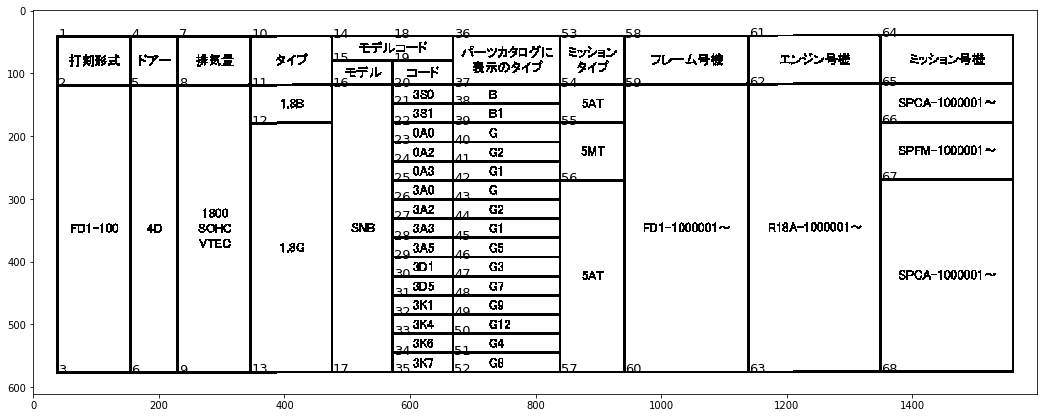

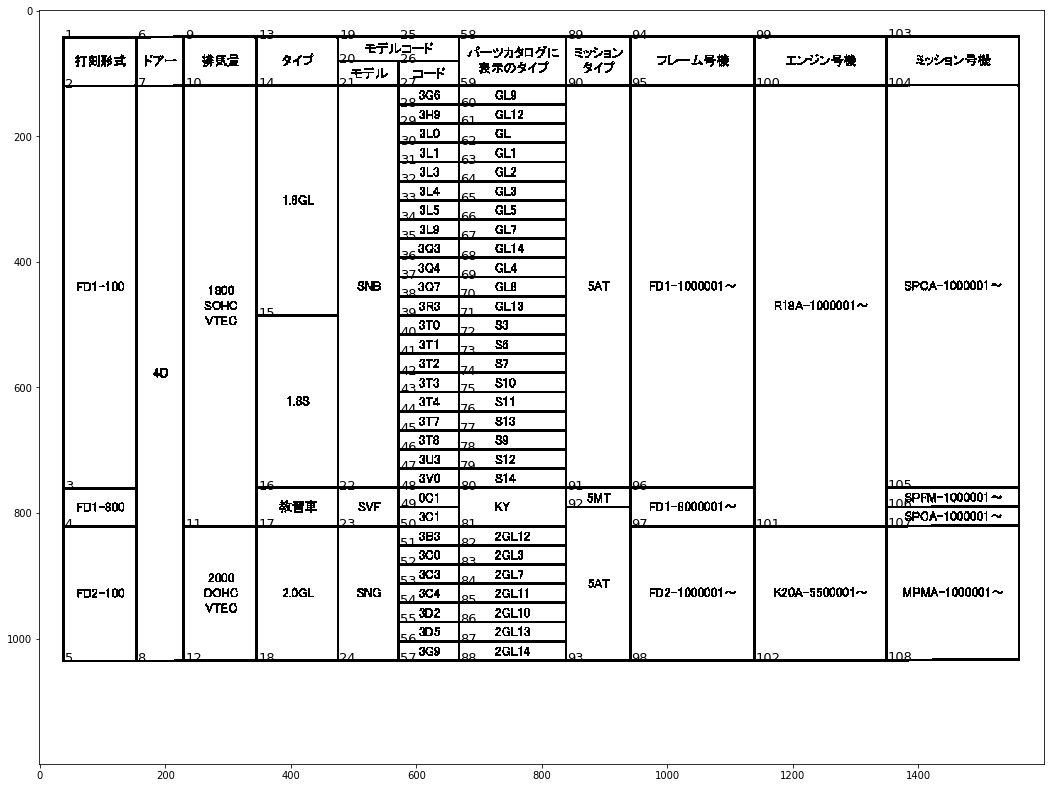

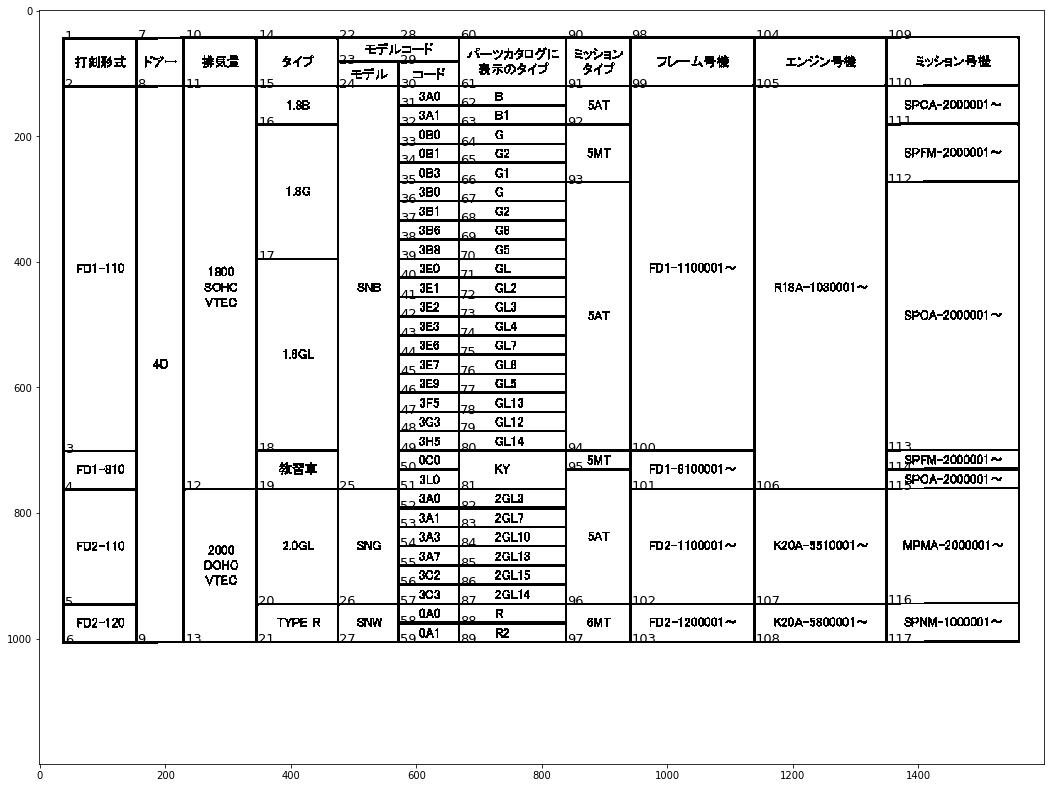

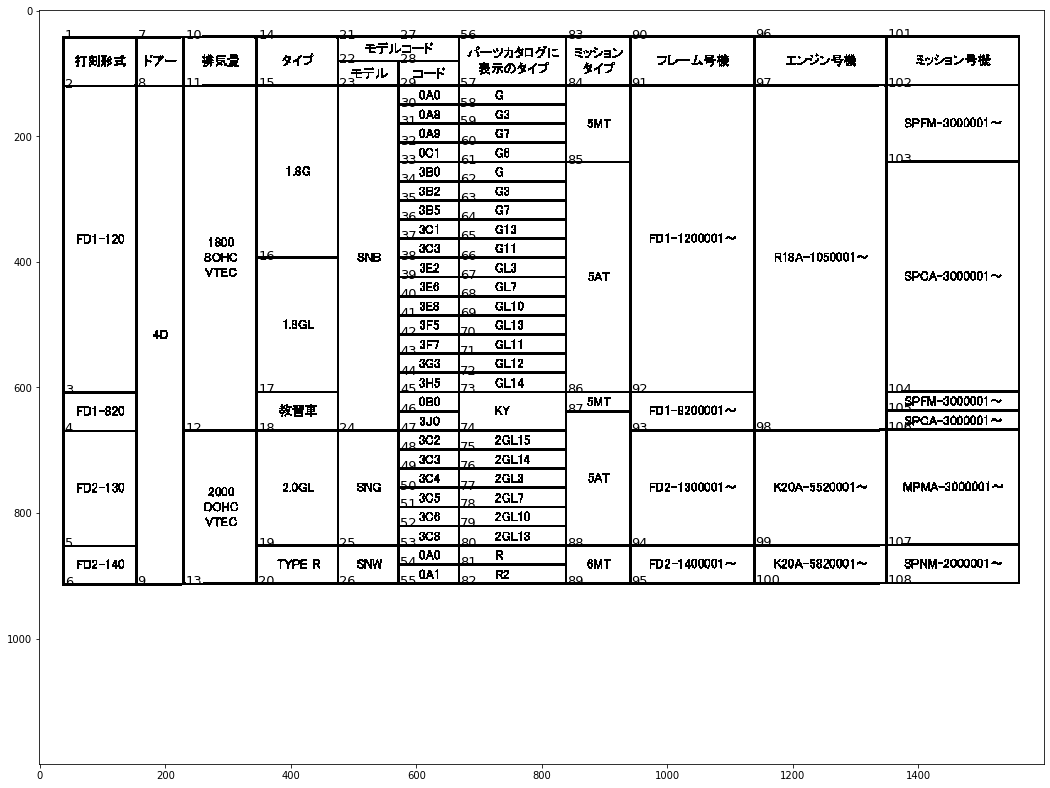

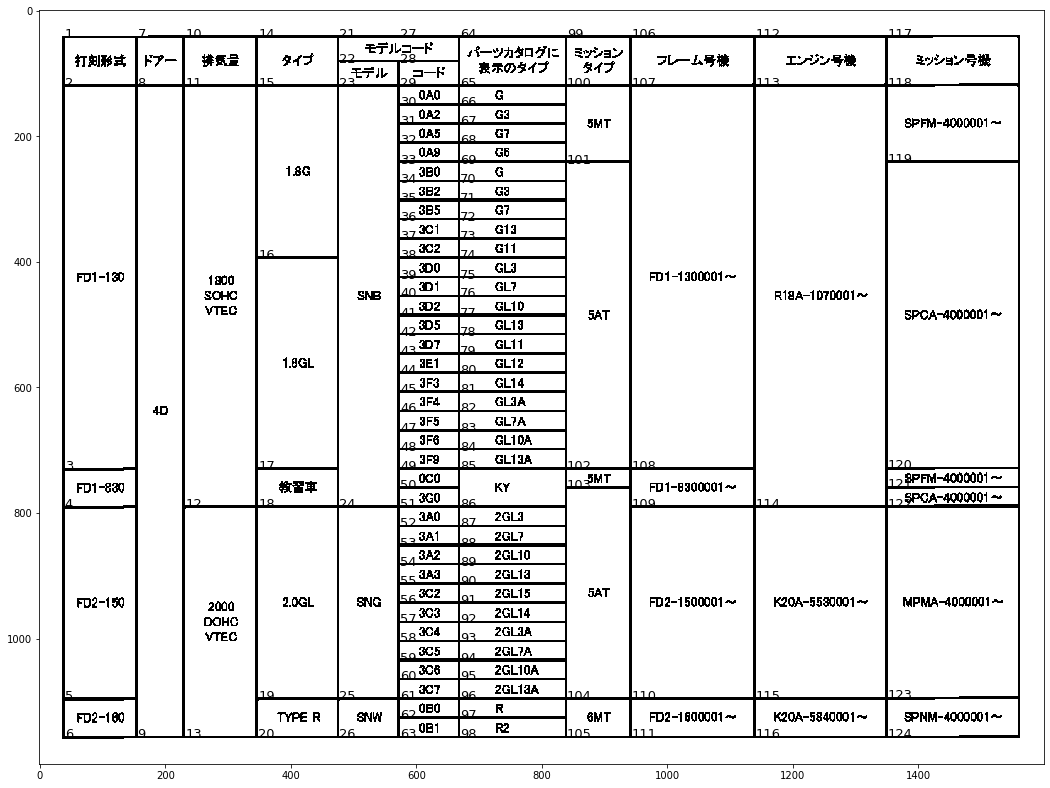

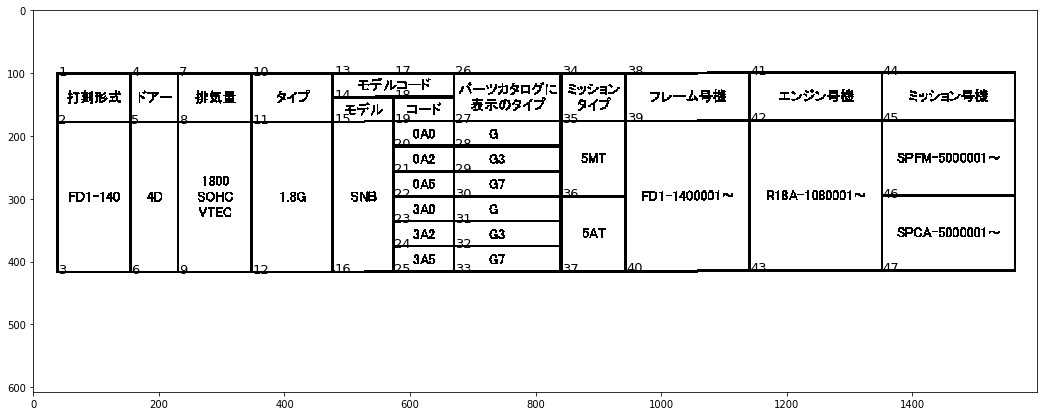

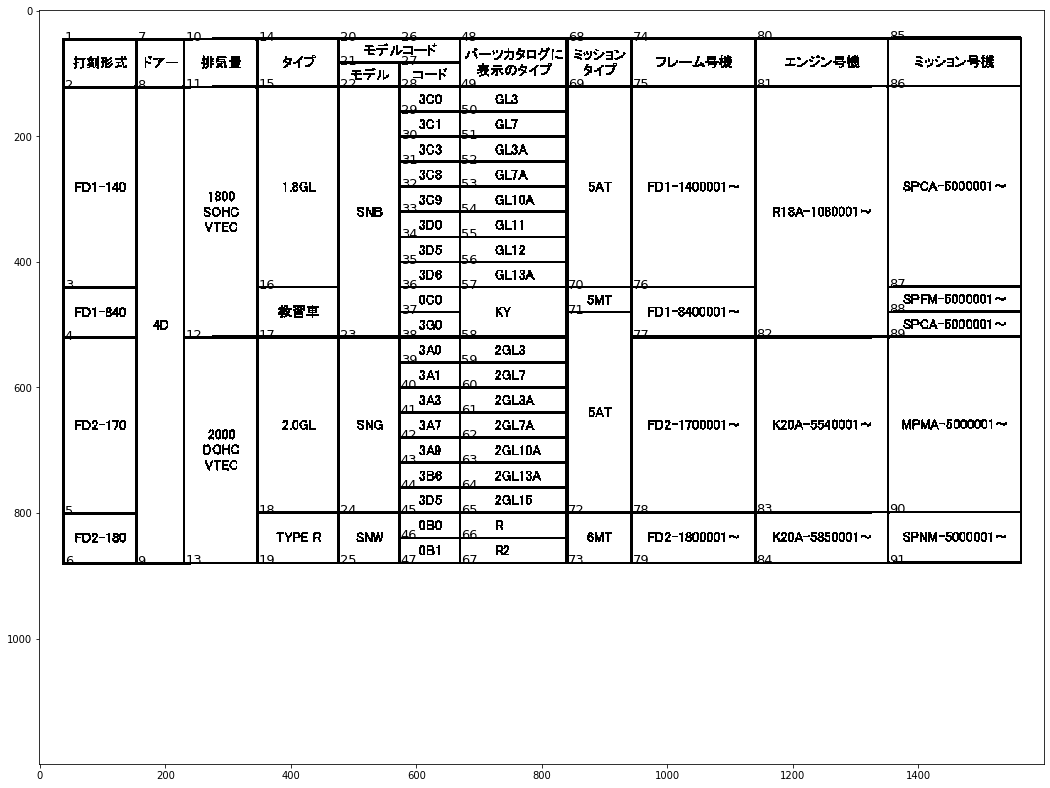

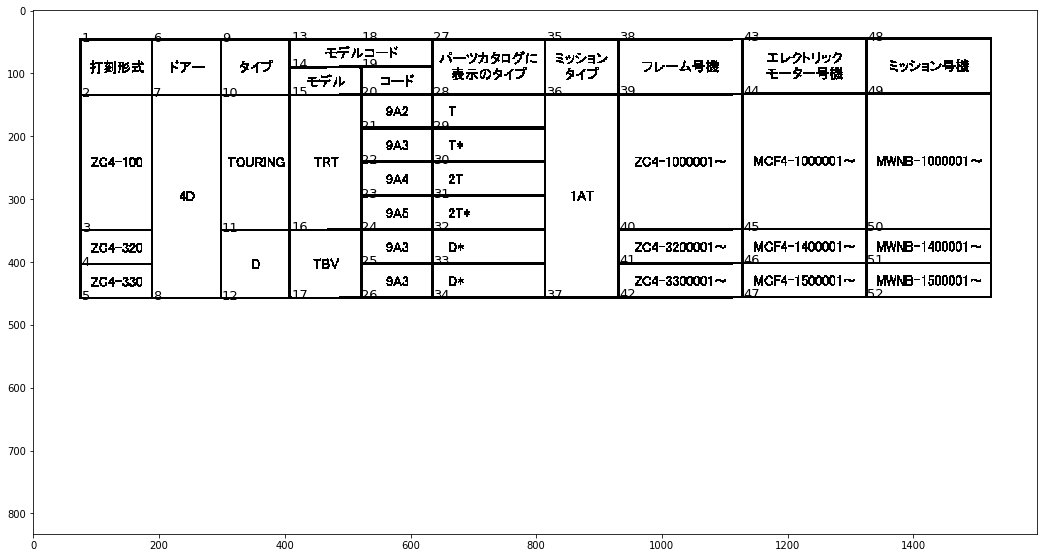

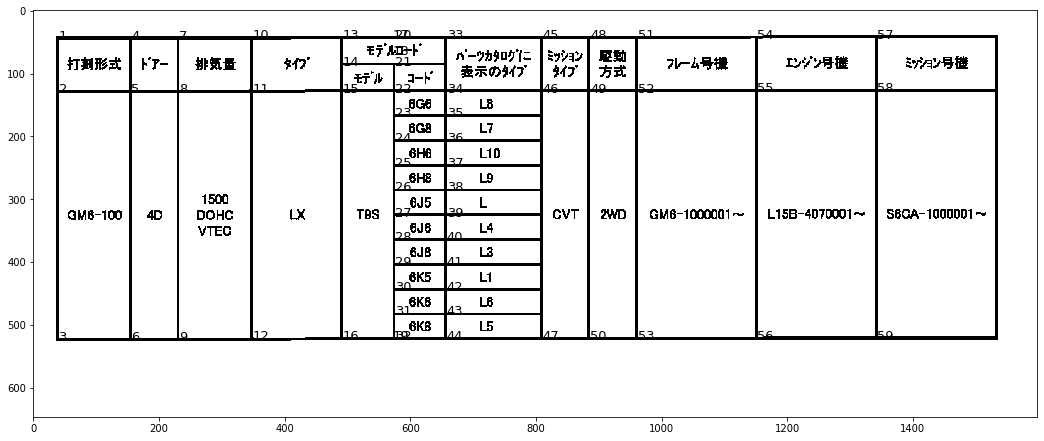

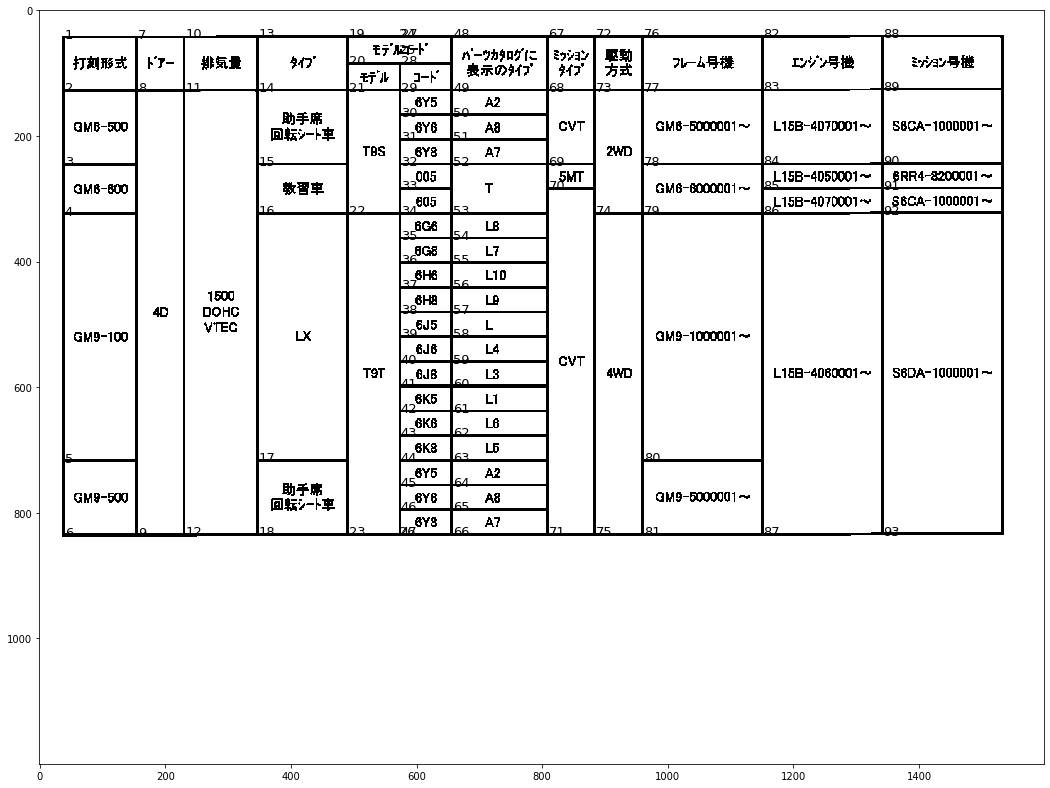

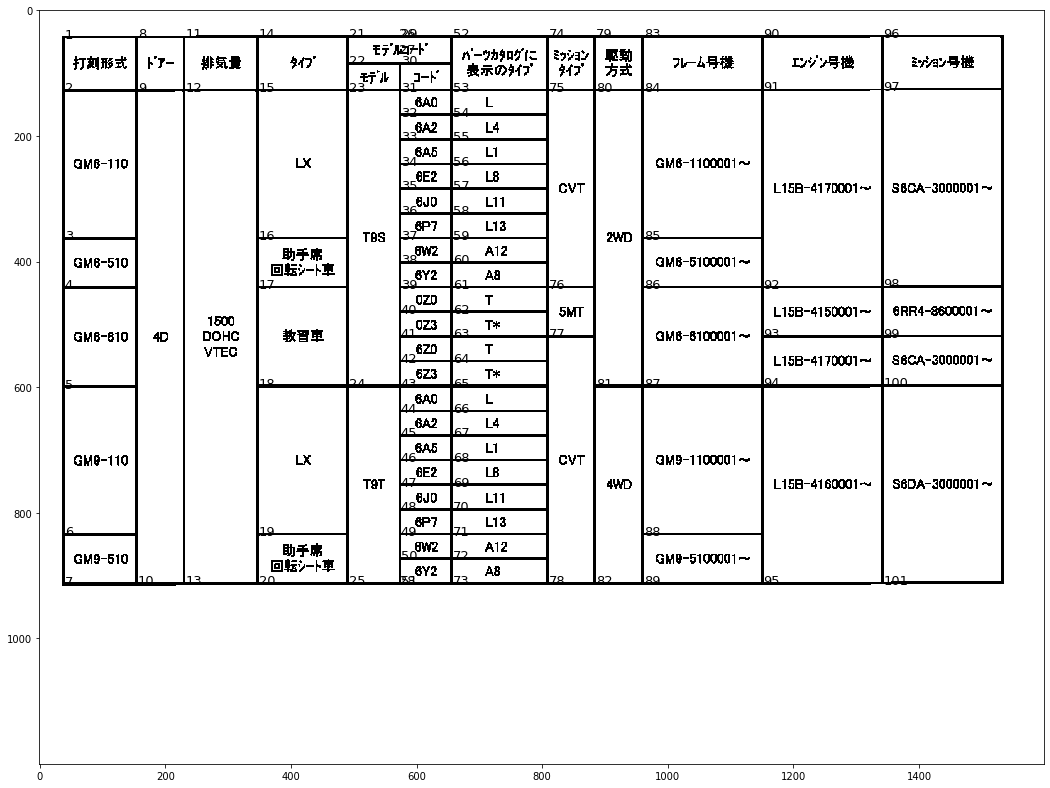

In [ ]:
#make_database(path):
DIR="./e-parts_scraping_copy"
image_counts=sum(os.path.isdir(os.path.join(DIR, name)) for name in os.listdir(DIR))
file_list=[name for name in os.listdir(DIR) if os.path.isdir(os.path.join(DIR,name))]

for _ in range(7,image_counts):
    DIR1=os.path.join(DIR,file_list[_])
    image_counts1=sum(os.path.isfile(os.path.join(DIR1, name)) for name in os.listdir(DIR1))
    file_list1=[name for name in os.listdir(DIR1) if os.path.isfile(os.path.join(DIR1,name))]
    file_list1.sort()
    if image_counts1==0:
        continue
    for i in range(image_counts1):
        print("{}をOCRにかけています。".format(file_list1[i]))
        print("{}枚目です。".format(i+1))
        #print(os.path.join(DIR1,file_list1[i]))
        try:
            if re.compile(r"-2018|-2019|-2020|-2021").search(file_list1[i]):
                    with open('text.txt', 'a', encoding='UTF-8') as f:
                        f.write("{}/n".format(file_list1[i]))  # ログを取る
                    continue
            data_perfect=make_database(os.path.join(DIR1,file_list1[i]))

            if i==0:
                data_perfects=data_perfect  
            else:
                data_perfects=pd.concat([data_perfects,data_perfect])
        except:
            with open('text.txt', 'a', encoding='UTF-8') as f:
                f.write("{}/n".format(file_list1[i]))  # ログを取る
                pass
            
        
    data_perfects.to_csv("./partsone",encoding="utf-8-sig",index=False)
    #data_perfects.to_csv("./data_folder"+"/"+file_list[_],encoding="utf-8-sig",index=False)
    print("保存しました。")
        

In [258]:
year=YearDictGen(''.join(year_text))

In [261]:
year_path="/Users/tetra/Desktop/partsone/work_space/year.png"
year_text=detect_year_text(YearImageCombine(year_path))
year=YearDictGen(''.join(year_text))

In [282]:
DetectTableByHistogram("/Users/tetra/Desktop/partsone/work_space/type_name.png")

IndexError: list index out of range

In [303]:
path="CIVIC 4D-2018_1.png"


220065

In [ ]:
#保存した号機管理表を上下に分けるコード。
def TableDivide(directory,img_path):
    img = cv2.imread(directory+img_path,0) #号機管理表を読み込む。
    
    ksize=9
    img_mask = cv2.bilateralFilter(img,ksize,75,75)
    #img_mask = cv2.medianBlur(img,ksize) #各ピクセルに対し、そこを中心に3*3のマスで輝度の平均を取る。
    
    #ピクセルの周りの白が２ピクセル以下であれば黒に、３以上であれば白に二値化される。黒のゴマ塩ノイズを消去するための処理
    
    #cv2.thresholdの第一引数は大値の二値化につかい、第二引数は、二値化した画像を出力する。
    ret, img_thresh = cv2.threshold(img_mask,60,255,cv2.THRESH_BINARY) 
    black_hist = []
    y_pixel = len(img_thresh) #順にy,xのピクセル数 
    x_pixel = len(img_thresh[0])
    
    for line in range(y_pixel):
        black_hist.append(np.sum(img_thresh[line])/255) #y軸の値に対し、横(x=const上)に白のピクセル数を取った合計※白=255,黒=0です
    
    breaks = []
    for i in reversed(range(1,y_pixel)):
        if (black_hist[i] == x_pixel) and (black_hist[i-1] != x_pixel): #yの値が大きい順から、y=Yで白一色だが、y=Y-1で白一色でないようなYを表のブレークとして格納
            breaks.append(i)
    breaks.sort()        
    
    #これ以後は、表の形によって変わる。
    #y座標のうち、全て白色のピクセルで構成されているものが、breaksに格納されている。
    if len(breaks)==4:
        year_table=img[breaks[1]:breaks[2]]
        cv2.imwrite('year.png', year_table)
        year_table=img[breaks[2]:breaks[3]]
        cv2.imwrite('type_name.png', year_table)
        

    else:
        year_table=img
        cv2.imwrite('type_name.png', year_table)

        
    
        
    return 'type_name.png','year.png' #cv2の行列形式で、切り取った表をreturn